In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
dt = 0.1                     #time step 1 second

Function = np.array([
    [  1, dt,  0,  0],   # X  = (1 * X) + (t * (dX / dt)) + (0 * Y) + (0 * (dY / dt))
    [  0,  1,  0,  0],   # Ux = (0 * X) + (1 * (dX / dt)) + (0 * Y) + (0 * (dY / dt))
    [  0,  0,  1, dt],   # Y  = (0 * X) + (0 * (dX / dt)) + (1 * Y) + (t * (dY / dt))
    [  0,  0,  0,  1]    # Uy = (0 * X) + (0 * (dX / dt)) + (0 * Y) + (1 * (dY / dt))
])

In [3]:
Q_k = np.eye(4) * 0.1
H_k = np.eye(4) * 1
R_k = np.eye(4) * 0.001

In [4]:
def predict(X_prev, P_prev):

    X_k = Function @ X_prev
    P_k = (Function @ P_prev @ Function.T) + (Q_k)

    return X_k, P_k 

In [242]:
def update(Z, X_prev, P_prev):
    Y_k = Z - (H_k @ X_prev)

    S_k = (H_k @ P_prev @ H_k.T) + (R_k)
    K_k = P_prev @ H_k.T @ np.linalg.pinv(S_k)
    X_k = X_prev + (K_k @ Y_k)
     
    P_k = P_prev - (K_k @ H_k @ P_prev)
     
    return X_k, P_k

In [346]:
def getZ():
    df = pd.read_csv(r'data1.csv')
    time_GPS = df.iloc[:, 0].values.tolist()
    time_OBD = df.iloc[:, 1].values.tolist()
    time_GPS = [x[11:19] for x in time_GPS]
    time_OBD = [x[12:] for x in time_OBD]
    time_GPS = [int(x[:2])*3600 + int(x[3:5])*60 + int(x[6:]) - 62295 for x in time_GPS] # перевод в секунды
    time_OBD = [int(x[:2])*3600 + int(x[3:5])*60 + float(x[6:]) - 62288.672 for x in time_OBD] # перевод в секунды

    Longitude = df.iloc[:, 2].values.tolist() # думаю, что это x
    Latitude = df.iloc[:, 3].values.tolist() # думаю, что это y
    Longitude = [float(x) * 63.995 * 1000 - 2405130.8281531497 for x in Longitude] # перевод в метры 
    Latitude = [float(x) * 111.1 * 1000 - 6204774.826019 for x in Latitude] # перевод в метры 

    speed_OBD = df.iloc[:, 13].values.tolist() # km/h
    speed_GPS = df.iloc[:, 16].values.tolist() # km/h

    speed_OBD = [float(x) * 1000 / 3600 for x in speed_OBD]
    speed_GPS = [float(x) * 1000 / 3600 if x != '-' else 0 for x in speed_GPS] # 

    Bearing = df.iloc[:, 7].values.tolist()
    Bearing = [np.deg2rad(x) for x in Bearing]

    speed_x = np.array([speed_GPS[0] * np.sin(Bearing[0])])
    speed_y = np.array([speed_GPS[0] * np.cos(Bearing[0])])

    for i in range(1, len(speed_GPS)):

        speed_GPS_x = np.append(speed_x, speed_GPS[i] * np.sin(Bearing[i]))
        speed_GPS_y = np.append(speed_y, speed_GPS[i] * np.cos(Bearing[i]))

        if time_GPS[i] == time_GPS[i - 1]:
            speed_x = np.append(speed_x, speed_OBD[i] * np.sin(Bearing[i]))
            speed_y = np.append(speed_y, speed_OBD[i] * np.cos(Bearing[i]))
        else:
            speed_x = np.append(speed_x, speed_GPS[i] * np.sin(Bearing[i]))
            speed_y = np.append(speed_y, speed_GPS[i] * np.cos(Bearing[i]))

    speed_DEL_x = speed_GPS_x
    speed_DEL_y = speed_GPS_y
    for i in range(len(speed_DEL_x)):
        if i in range(random.randint(10000, 20000), random.randint(30000, 40000)):
            speed_DEL_x[i] = 0
            speed_DEL_y[i] = 0
        

    Z1_k = np.array([Longitude, Latitude, speed_x, speed_y]).T
    Z2_k = np.array([Longitude, Latitude, speed_GPS_x, speed_GPS_y]).T
    Z3_k = np.array([Longitude, Latitude, speed_DEL_x, speed_DEL_y]).T
    return Z1_k, Z2_k, Z3_k, time_GPS, time_OBD

In [353]:
X_k = np.array([0.0, 0.0, 0.0, 0.0]).T
P_k = np.eye(4) * 500
Z1_k, Z2_k, Z3_k, time_GPS, time_OBD = getZ()
result_x = np.array([])
result_y = np.array([])
result_ux = np.array([])
result_uy = np.array([])
result_del_ux = np.array([])
result_del_uy = np.array([])
result_gps_ux = np.array([])
result_gps_uy = np.array([])
result1_x = np.array([])
result1_y = np.array([])

for k in Z1_k:
    X_k, P_k = predict(X_k, P_k)     
    X_k, P_k = update(k, X_k, P_k)
    result_x = np.append(result_x, X_k[0])
    result_y = np.append(result_y, X_k[1])
    result_ux = np.append(result_ux, X_k[2])
    result_uy = np.append(result_uy, X_k[3])

for k in Z2_k:
    X_k, P_k = predict(X_k, P_k)     
    X_k, P_k = update(k, X_k, P_k)
    result_gps_ux = np.append(result_gps_ux, X_k[2])
    result_gps_uy = np.append(result_gps_uy, X_k[3])


for k in Z3_k:
    X_k, P_k = predict(X_k, P_k)     
    X_k, P_k = update(k, X_k, P_k)
    result_del_ux = np.append(result_del_ux, X_k[2])
    result_del_uy = np.append(result_del_uy, X_k[3])

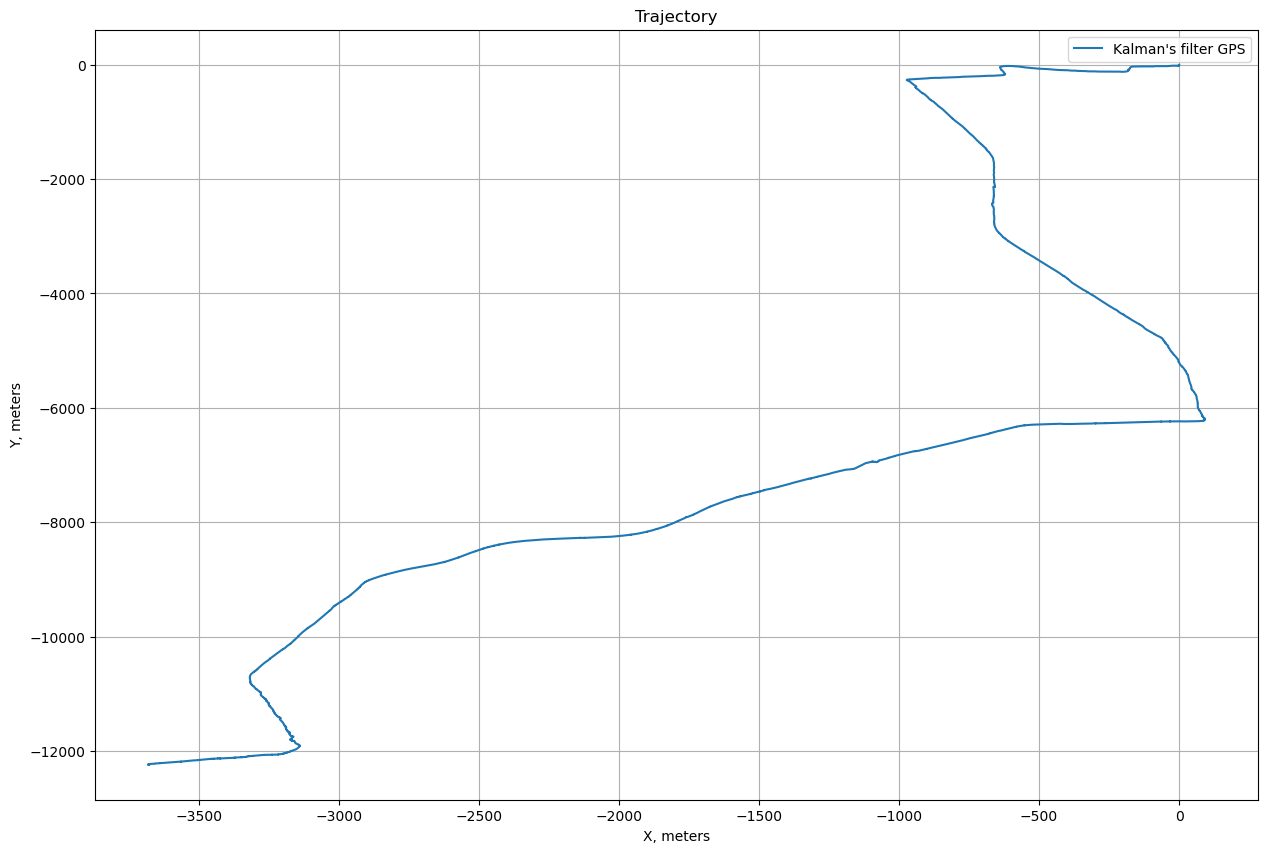

In [355]:
plt.figure(figsize=(15, 10))
plt.plot(result_x, result_y, label="Kalman's filter GPS")
plt.title('Trajectory')
plt.xlabel('X, meters')
plt.ylabel('Y, meters')
plt.legend()
plt.grid(True)

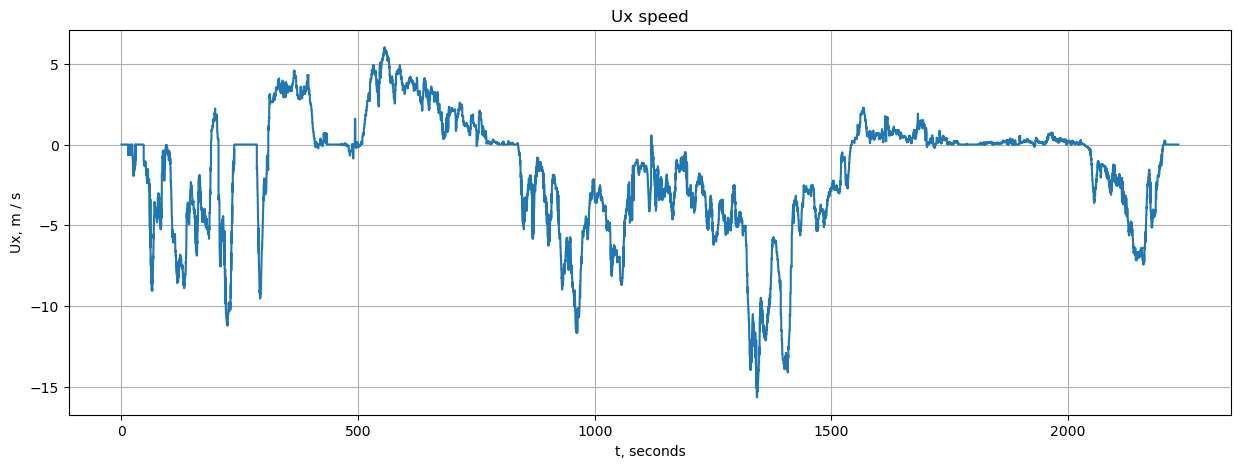

In [349]:
plt.figure(figsize=(15, 5))
plt.plot(time_OBD, result_ux)
plt.title('Ux speed')
plt.xlabel('t, seconds')
plt.ylabel('Ux, m / s')
plt.grid(True)

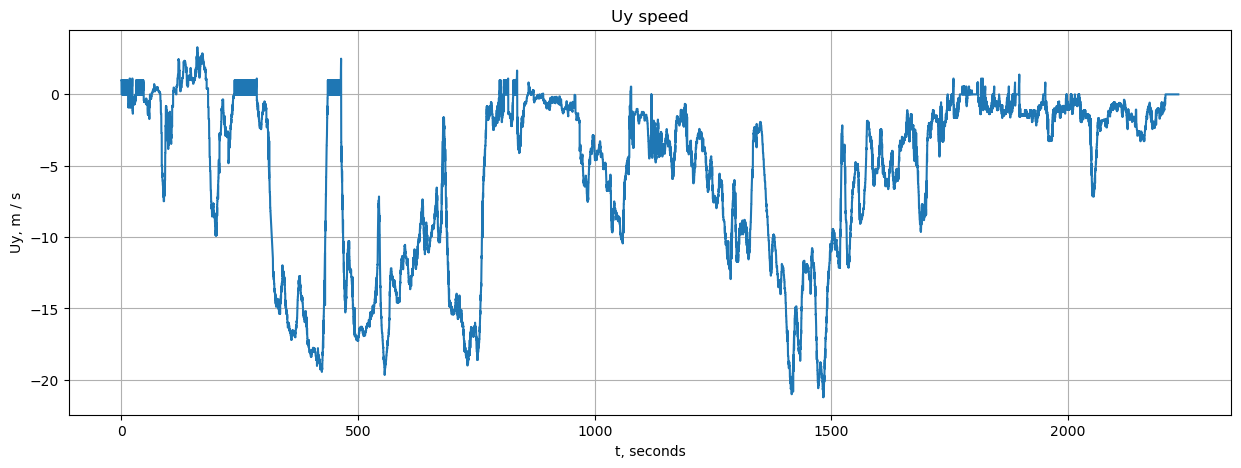

In [350]:
plt.figure(figsize=(15, 5))
plt.plot(time_OBD, result_uy)
plt.title('Uy speed')
plt.xlabel('t, seconds')
plt.ylabel('Uy, m / s')
plt.grid(True)

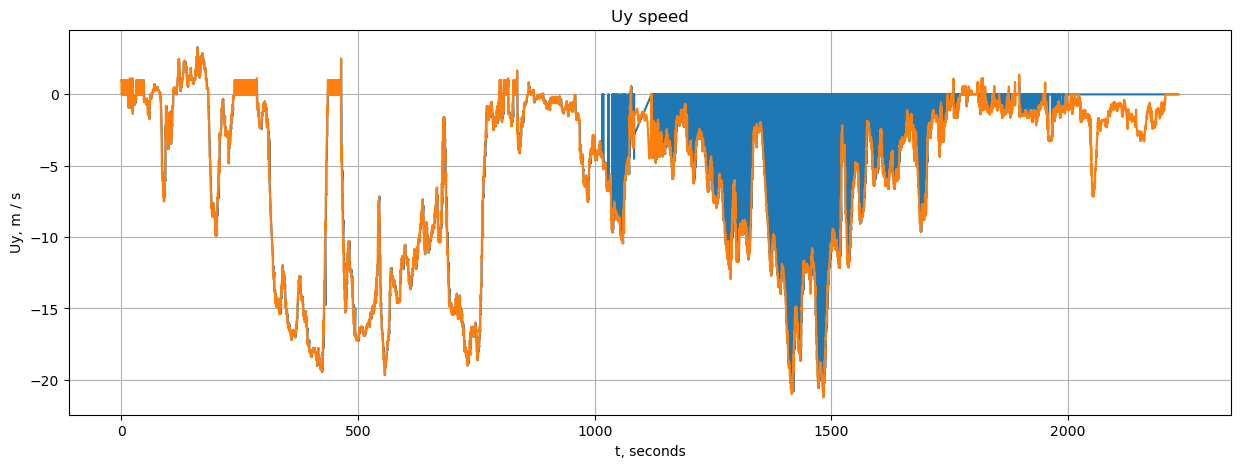

In [351]:
plt.figure(figsize=(15, 5))
plt.plot(time_GPS, result_del_uy)
plt.plot(time_OBD, result_uy)
plt.title('Uy speed')
plt.xlabel('t, seconds')
plt.ylabel('Uy, m / s')
plt.grid(True)